### Monte Carlo Approach
<p>Monte Carlo methods are any process that consumes random numbers. These are part of computational algorithms which are based on random sampling to obtain numerical results. Monte Carlo methods are proved to be a very valuable and flexible computational tool in finance and is one of the most widely used methods for optimization and numerical integration problems.</p>

These methods are widely used in high dimensional problems; pricing exotics and complex derivatives where closed form solutions are not directly available. Monte Carlo methods are not just adapted in pricing complex derivatives, It is also extensively used in estimating the portfolio risk such as Value-at-Risk and Expected Shortfall and used in the calculation of worst-case scenarios in stress testing. The downside to that is, it is very computational intensive and demanding.

### Monte Carlo Simulation
A method of estimating the value of an unknown quantity using the principles of inferential statistics.

We take the population and then we sample it by drawing a proper subset. And then we make an inference about the population based upon some set of statistics we do on the sample.

And, the key fact that makes them work, that if we choose the sample at random, the sample will tend to exhibit the same properties as the population from which it is drawn.

### Option Pricing Techniques
As with other option pricing techniques Monte Carlo methods are used to price options using what is essentially a three step process.

Step 1: Simulate potential price paths of the underlying asset.
Step 2: Calculate the option payoff for each of these price paths.
Step 3: Average the payoff and discount back to today to determine the option price.

### Simulating Asset Prices
Next, we will simulate the asset price at maturity 
S
T
. Following Black-Scholes-Merton where the underlying follows under risk neutrality, a geometric Brownian motion with a stochastic differential equation (SDE) is given as

$$ dS_{t} = rS_{t}dt + σ S_{t}W_{t} $$
where $S_{t}$ is the price of the underlying at time $t$, σ is constant volatility, $r$ is the constant risk-free interest rate and $W$ is the brownian motion.
Applying Euler discretization of SDE, we get

$$S_{t+δt} =S_{t}  (1 + r\delta t + σ\sqrt{δtw_{t}}$$
It is often more convenient to express in time stepping form

$$S_{t+δt} =S_{t}exp^((r - \frac{1}{2} \sigma^2)δt + σ\sqrt{δtw_{t}}$$

The variable w is a standard normally distributed random variable, 0 < δt < T, time interval. It also holds 0 < t ≤ T with T the final time horizon.

### Generate Price Paths
Simulating price paths plays an important role in the valuation of derivatives and it is always prudent to create a separate path function.

### Import Required Libraries

In [9]:
# Importing libraries
import warnings
warnings.filterwarnings('ignore')

from pydantic import BaseModel, Field, ValidationError, field_validator, validator
from typing import List, Tuple
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Set max row to 300
pd.set_option('display.max_rows', 300)

In [12]:

# Monte Carlo Option Object
class MonteCarloOptionPricing(BaseModel):
    """Monte Carlo Option Pricing Engine"""

    S0: float = Field(..., gt=0, description="Initial stock price")
    K: float = Field(..., gt=0, alias="strike", description="Strike price")
    r: float = Field(..., ge=0, le=1, alias="rate", description="Risk-free rate")
    sigma: float = Field(..., gt=0, le=1, description="Volatility")
    T: int = Field(..., gt=0, le=3650, alias="dte", description="Days to expiration")
    N: int = Field(..., gt=0, alias="nsim", description="Number of simulations")
    ts: int = Field(252, gt=0, alias="timesteps", description="Number of timesteps")

    class Config:
        allow_population_by_field_name = True

    # alternate way to validate
    #@field_validator('T')
    # def check_T(cls, v):
    #     if v > 365 * 10:  # Assuming max 10 years
    #         raise ValueError("Days to expiration should not exceed 3650 (10 years)")
    #     return v
    
    @field_validator('N')
    def check_N(cls, v):
        if v > 1_000_000:  # Assuming max 1 million simulations
            raise ValueError("Number of simulations should not exceed 1,000,000")
        return v

    @property
    def df(self) -> float:
        return np.exp(-self.r * self.T)

    @property
    def pseudorandomnumber(self) -> np.ndarray:
        return np.random.standard_normal(self.N)

    @property
    def simulatepath(self) -> np.ndarray:
        """Simulate price path"""
        np.random.seed(2024)

        dt = self.T / self.ts

        S = np.zeros((self.ts, self.N))
        S[0] = self.S0

        for i in range(0, self.ts-1):
            w = self.pseudorandomnumber
            S[i+1] = S[i] * (1 + self.r*dt + self.sigma*np.sqrt(dt)*w)

        return S

    @property
    def vanillaoption(self) -> List[float]:
        """Calculate vanilla option payoff"""
        S = self.simulatepath

        vanilla_call = self.df * np.mean(np.maximum(0, S[-1] - self.K))
        vanilla_put = self.df * np.mean(np.maximum(0, self.K - S[-1]))

        return [vanilla_call, vanilla_put]

    @property
    def asianoption(self) -> List[float]:
        """Calculate asian option payoff"""
        S = self.simulatepath

        A = S.mean(axis=0)

        asian_call = self.df * np.mean(np.maximum(0, A - self.K))
        asian_put = self.df * np.mean(np.maximum(0, self.K - A))

        return [asian_call, asian_put]

    def upandoutcall(self, barrier: int = 150, rebate: int = 0) -> Tuple[float, float]:
        """Calculate up-and-out call option payoff"""
        S = self.simulatepath

        # Barrier shift
        barriershift = barrier * np.exp(0.5826 * self.sigma * np.sqrt(self.T/self.ts))

        value = 0
        for i in range(self.N):
            if S[:,i].max() < barriershift:
                value += np.maximum(0, S[-1,i] - self.K)
            else:
                value += rebate

        return self.df * value / self.N, barriershift

In [13]:
# Monte Carlo Option Object
try:
    option1 = MonteCarloOptionPricing(
            S0=100,
            strike=100,
            rate=0.05,
            sigma=0.2,
            dte=1,
            nsim=100000,
            timesteps=252
        )
except ValidationError as e:
    print(f"\nValidation error: {e}")

In [14]:
# Verify the generated price paths using dataframe
pd.DataFrame(option1.simulatepath).head(2)

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.00000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.00000,100.000000,100.000000
1,102.121383,100.948812,99.765928,99.82971,101.173958,101.481719,96.718999,98.350127,100.599372,100.148414,...,100.34369,101.838621,99.128963,100.129858,97.246274,99.60355,101.377545,99.49875,98.363364,99.097818


In [15]:
# Get last few rows
pd.DataFrame(option1.simulatepath).tail(2)

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
250,141.437673,119.854615,90.473423,147.121107,124.461143,83.101166,111.542425,124.106212,116.674454,163.886254,...,105.746454,107.471261,115.694412,123.081588,113.559476,90.912640,70.243959,77.676287,112.050906,103.906380
251,142.982456,120.072472,90.316633,148.781911,122.771249,84.048953,113.849639,124.499340,117.936273,167.296821,...,106.739564,106.694851,115.834640,123.167677,112.881114,91.791613,70.620528,76.259556,112.470420,103.800921


Histogram of Psuedo Random Numbers

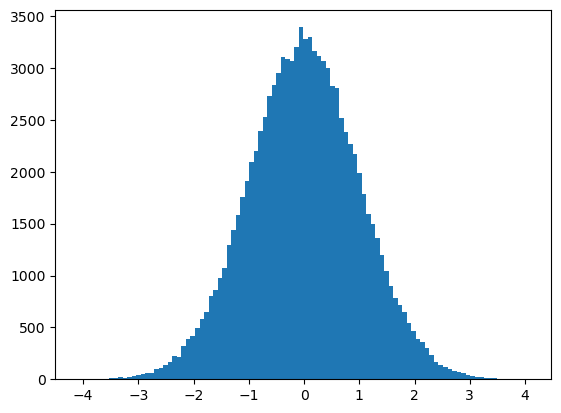

In [16]:
pseudorandom = option1.pseudorandomnumber

# Plot the histogram with bins=100
plt.hist(pseudorandom, bins=100);

In [17]:
# mean and standard deviation of pseudorandom numbers
pseudorandom.mean(), pseudorandom.std()

(-0.00028160722026104027, 0.9987677234824759)

### Histogram of Simulated Paths

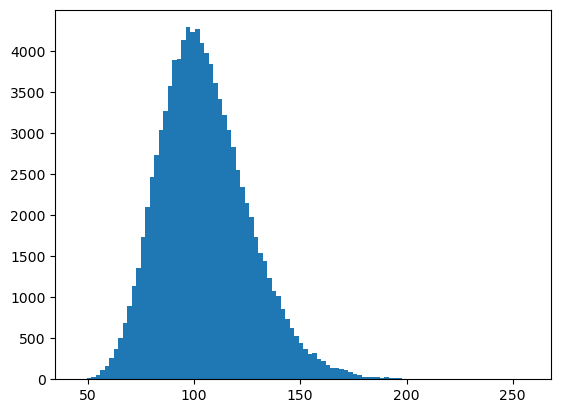

In [18]:
# Plot the histogram of the simulated price path at maturity
plt.hist(option1.simulatepath[-1], bins=100);

### Visualization of Simulated Paths

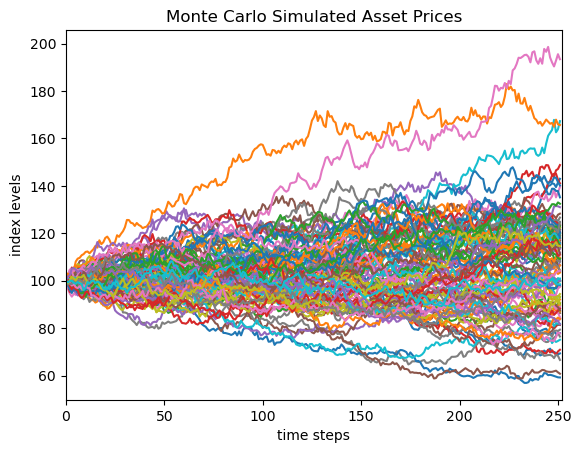

In [19]:
# Plot initial 100 simulated path using matplotlib
plt.plot(option1.simulatepath[:,:100])
plt.xlabel('time steps')
plt.xlim(0,252)
plt.ylabel('index levels')
plt.title('Monte Carlo Simulated Asset Prices');

### Risk-Neutral Valuation
<p>A call option gives the holder of the option the right to buy the asset at a pre-defined price. A call buyer makes money if the price of the asset at maturity, denoted by $S_{T}$, is above the strike price $K$, otherwise it's worth nothing.</p>

$$ C_{T} = max(0,S_{T} = K) $$

The price of an option using a Monte Carlo simulation is the expected value of its future payoff. So at any date before maturity, denoted by $t$, the option's value is the present value of the expectation of its payoff at maturity, $T$.

$$ C = PV(E[max(0,S_{T} - K)]) $$

Under the risk-neutral framework, we assume the asset is going to earn, on average, the risk-free interest rate. Hence, the option value at time $t$ would simply be the discounted value of the expected payoff.

$$ C = e^-r(T-t)(E[max(0,S_{T} - k)]) $$

European Option
To price an option, we generate many possible price paths that the asset might take at maturity and then calculate option payoffs for each of those generated prices, average them to get the expected payoff and then discount it at risk free to arrive at the final value.

Given that Monte Carlo algorithms are computationaly heavy, it is necessary to implement efficiently. We'll use vectorization with NumPy for effective algorithm as NumPy syntax are more compact and are faster.

In [20]:
# Get option vaues 
print(f"European Call Option Value is {option1.vanillaoption[0]:0.4f}")
print(f"European Put Option Value is {option1.vanillaoption[1]:0.4f}")

European Call Option Value is 10.4352
European Put Option Value is 5.5305


### Asian Call Option
<p>An Asian option is an option where the payoff depends on the average price of the underlying asset over a certain period of time. Averaging can be either be Arithmetic or Geometric. There are two types of Asian options: fixed strike, where averaging price is used in place of underlying price; and fixed price, where averaging price is used in place of strike.</p>

We'll now price a fixed strike arthmetic average option using Monte Carlo simulation.

### The payoff of the options is given by

$$ C_{T} = max(0, \frac{1}{T}Σ^T_{i=1}S_{i} - K) $$
$$ C_{T} = max(0, S_{Avg} - K) $$

where $ S_{Avg} $ is the average price of the underlying asset over the life of the option. To price an option using a Monte Carlo simulation we use a risk-neutral valuation, where the fair value for a derivative is the expected value of its future payoff. So at any date before maturity, denoted by $t$, the option's value is the present value of the expectation of its payoff at maturity, $T$.

$$ C = PV(E[max(0,S_{Avg} - K)]) $$

Under the risk-neutral framework, we assume the asset is going to earn, on average, the risk-free interest rate. Hence, the option value at time $t$ would simply be the discounted value of the expected payoff.

$$ C = e^-r(T-t) (E[max(0, S_{Avg} - K)]) $$

In [21]:
# Get option values
print(f"Asian Call Option Value is {option1.asianoption[0]:0.4f}")
print(f"Asian Put Option Value is {option1.asianoption[1]:0.4f}")

Asian Call Option Value is 5.7251
Asian Put Option Value is 3.3246


### Up-and-out Barrier Call Option
<p>Barrier Options are path dependent exotic options whose payoff depends on whether the price of the underlying asset crosses a pre specified level (called the ‘barrier’) before the expiration. The four main types of barrier options are:</p>

Up-and-out
Down-and-out
Up-and-in
Down-and-in

Refer Paul Wilmott on Quantitative Finance Chapter 23 — Barrier Options and Chapter 77 — Finite Difference Methods for One-factor Models for further details on barriers.

Next, we will price a Up-Out-Call barrier with and without rebate using Monte Carlo simulation. Barrier options can be priced using analytical solutions if we assume continuous monitoring of the barrier. However, in reality many barrier contracts specify discrete monitoring.

In a paper titled A Continuity Correction for Discrete Barrier Option, Mark Broadie, Paul Glasserman and Steven Kou have shown us that the discrete barrier options can be priced using continuous barrier formulas by applying a simple continuity correction to the barrier. The correction shifts the barrier away from the underlying by a factor of

$$ exp^(β\sigma\sqrt{Δt}) $$

where β ≈0.5826 and σ is the underlying volatility, and Δt is the time between monitoring instants. We will apply this continuity correction in our pricing method as well.

In [22]:
# Get barrier option values for B=150 and rebate=0
print(f"Up-and-Out Barrier Call Option Value is {option1.upandoutcall()[0]:0.4f}")

Up-and-Out Barrier Call Option Value is 8.0192


### Plot Payoff

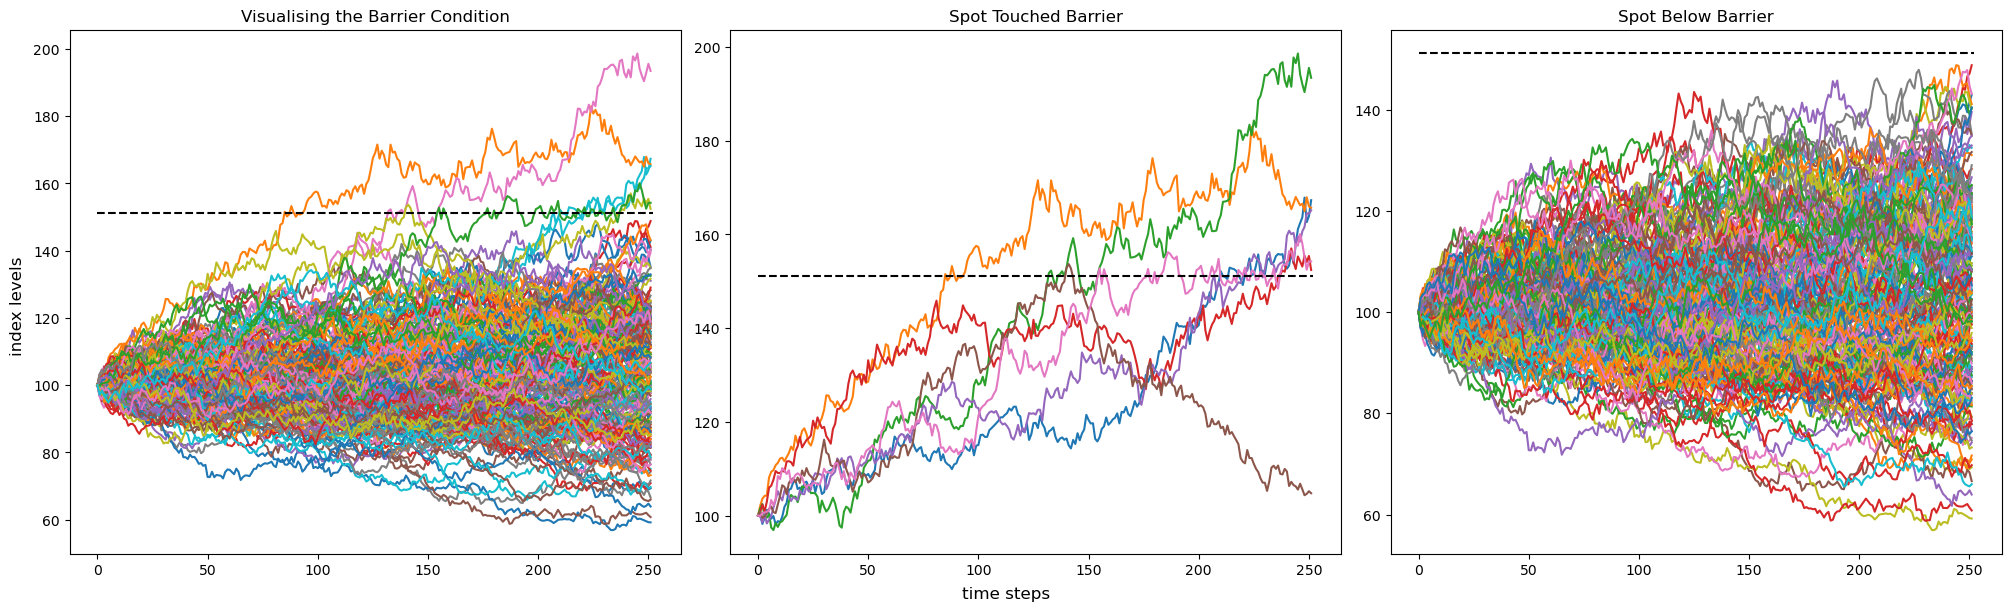

In [23]:
figure, axes = plt.subplots(1,3, figsize=(20,6), constrained_layout=True)
title = ['Visualising the Barrier Condition', 'Spot Touched Barrier', 'Spot Below Barrier']

# Get simulated path
S = option1.simulatepath
B_shift = option1.upandoutcall()[1]

axes[0].plot(S[:,:200])      
for i in range(200):
    axes[1].plot(S[:,i]) if S[:,i].max() > B_shift else axes[2].plot(S[:,i])

for i in range(3):
    axes[i].set_title(title[i])
    axes[i].hlines(B_shift, 0, 252, colors='k', linestyles='dashed')

figure.supxlabel('time steps')
figure.supylabel('index levels')

plt.show()